<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1">Preprocessing</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-2">Models</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-2.1">SVM</a></span></li><li><span><a href="#MLP" data-toc-modified-id="MLP-2.2">MLP</a></span></li><li><span><a href="#RNN" data-toc-modified-id="RNN-2.3">RNN</a></span><ul class="toc-item"><li><span><a href="#GRU" data-toc-modified-id="GRU-2.3.1">GRU</a></span></li></ul></li></ul></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-3">Save results</a></span></li></ul></div>

# Preprocessing

In [1]:
import torchtext
import spacy

#Embeddings
word_dim = 100
glove = torchtext.vocab.GloVe(name='6B', dim=word_dim)

#tokenizer model
nlp_en = spacy.load('en300')

In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

wv_from_bin = KeyedVectors.load_word2vec_format("data/model.bin", binary=True) 

In [3]:
import string
import jieba
import gensim 
import spacy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

stop_words = [line.rstrip() for line in open('data/chinese_stop_words.txt',"r", encoding="utf-8") ]

def get_sentence_vector_zh(line, mode):
    vectors = []
    for w in line:
        try:
            emb = wv_from_bin[w]
            vectors.append(emb)
        except:
            pass #Do not add if the word is out of vocabulary
    if vectors:
        vectors = np.array(vectors)
        # Outputs vector of shape (1)
        if mode==0:
            vectors = np.mean(vectors) 
        # Outputs vector of shape (word_dim)
        elif mode==1:
            vectors = np.mean(vectors, axis=0)
        # Outputs vector of shape (len(line), word_dim)
        elif mode==2:
            vectors = vectors
        return vectors
    else:
        if mode==0 or mode==1:
            return np.zeros(word_dim)
        elif mode==2:
            return np.zeros((1, word_dim), dtype=np.float32)


def processing_zh(sentence):
    seg_list = jieba.lcut(sentence,cut_all=True)
    doc = [word for word in seg_list if word not in stop_words]
    docs = [e for e in doc if e.isalnum()]
    return docs


def get_sentence_embeddings_zh(f, mode=0):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in lines:
        sent  = processing_zh(l)
        vec = get_sentence_vector_zh(sent, mode=mode)
        if vec is not None:
            sentences_vectors.append(vec)
        else:
            print(l)
    return sentences_vectors

In [4]:
from nltk.corpus import stopwords
from tqdm import tqdm 

stop_words_en = set(stopwords.words('english'))

def preprocess(sentence,nlp):
    text = sentence.lower()
    doc = [token.lemma_ for token in  nlp.tokenizer(text)]
    doc = [word for word in doc if word not in stop_words_en]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

def get_word_vector(embeddings, word):
    try:
        vec = embeddings.vectors[embeddings.stoi[word]]
        return vec
    except KeyError:
        #print(f"Word {word} does not exist")
        pass

def get_sentence_vector(embeddings,line,mode):
    vectors = []
    for w in line:
        emb = get_word_vector(embeddings,w)
        #do not add if the word is out of vocabulary
        if emb is not None:
            vectors.append(emb)
    # Outputs vector of shape (1)
    if mode==0:
        vectors = torch.mean(torch.stack(vectors))
    # Outputs vector of shape (word_dim)
    elif mode==1:
        vectors = torch.mean(torch.stack(vectors), axis=0)
    # Outputs vector of shape (len(line), word_dim)
    elif mode==2:
        vectors = torch.stack(vectors)
    return vectors.data.numpy()


def get_embeddings(f,embeddings,lang, mode=0):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in lines:
        sentence = preprocess(l,lang)
        try:
            vec = get_sentence_vector(embeddings,sentence,mode)
            sentences_vectors.append(vec)
        except:
            if mode == 0 or mode == 1:
                sentences_vectors.append(np.zeros(word_dim))
            if mode == 2:
                print("Check if the dimension is correct")
                sentences_vectors.append(np.zeros((1, word_dim), dtype=np.float32))
    return sentences_vectors

In [17]:
import spacy
import torchtext
from torchtext import data

zh_train_mt = get_sentence_embeddings_zh("data/en-zh/train.enzh.mt", mode=1)
zh_train_src = get_embeddings("data/en-zh/train.enzh.src", glove, nlp_en, mode=1)
f_train_scores = open("data/en-zh/train.enzh.scores",'r')
zh_train_scores = f_train_scores.readlines()

zh_val_src = get_embeddings("data/en-zh/dev.enzh.src", glove, nlp_en, mode=1)
zh_val_mt = get_sentence_embeddings_zh("data/en-zh/dev.enzh.mt", mode=1)
f_val_scores = open("data/en-zh/dev.enzh.scores",'r')
zh_val_scores = f_val_scores.readlines()

In [18]:
print(f"Training mt: {len(zh_train_mt)} Training src: {len(zh_train_src)}")
print(f"Validation mt: {len(zh_val_mt)} Validation src: {len(zh_val_src)}")

Training mt: 7000 Training src: 7000
Validation mt: 1000 Validation src: 1000


In [19]:
import numpy as np

X_train = np.concatenate((np.asarray(zh_train_src), np.asarray(zh_train_mt)),axis=1) #[np.array(zh_train_src),np.array(zh_train_mt)]
X_train_zh = np.array(X_train).transpose()

X_val = np.concatenate((zh_val_src, zh_val_mt),axis=1) # [np.array(zh_val_src),np.array(zh_val_mt)]
X_val_zh = np.array(X_val).transpose()

#Scores
train_scores = np.array(zh_train_scores).astype(float)
y_train_zh = train_scores

val_scores = np.array(zh_val_scores).astype(float)
y_val_zh = val_scores

In [8]:
def rmse(predictions, targets):
    res = np.sqrt(((predictions - targets) ** 2).mean())
    return res

In [9]:
def pearsonr_loss(x, y):
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return 1 - r_val**2

In [10]:
def plot_loss(losses):
    import matplotlib.pyplot as plt
    plt.plot(list(range(len(losses))), losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training")
    plt.yscale('log')
    plt.show()

# Models

## SVM

In [42]:
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error

for k in ['linear','poly','rbf','sigmoid']:
    clf_t = SVR(kernel=k, gamma='scale')
    clf_t.fit(X_train, y_train_zh)
    print(k)
    predictions = clf_t.predict(X_val)
    pearson = pearsonr(y_val_zh, predictions)
    print(f'RMSE: {rmse(predictions,y_val_zh)} Pearson: {pearson[0]} MAE: {mean_absolute_error(predictions,y_val_zh)}')
    print()

linear
RMSE: 0.916367867970018 Pearson: 0.2636427869112175 MAE: 0.6691151115976675

poly
RMSE: 0.9018260976746194 Pearson: 0.29146167513787086 MAE: 0.6669503361589965

rbf
RMSE: 0.8990911961061968 Pearson: 0.3167253478675417 MAE: 0.6557439658137058

sigmoid
RMSE: 6.05641224946189 Pearson: -0.04217794554400104 MAE: 4.015346687593329



In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 0, verbose=2, n_jobs=-1)
rf.fit(X_train, y_train_zh);
predictions = rf.predict(X_val)

pearson = pearsonr(y_val_zh, predictions)
print('RMSE:', rmse(predictions,y_val_zh))
print(f"Pearson {pearson[0]}")
print(f"MAE: {mean_absolute_error(predictions,y_val_zh)}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000
building tree 4 of 1000building tree 5 of 1000
building tree 6 of 1000building tree 7 of 1000building tree 8 of 1000





building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.8s


building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.4s


building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min


building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.7min


building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tre

building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000building tree 981 of 1000

building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


RMSE: 0.8806199443169025
Pearson 0.2525028087256358
MAE: 0.7130026813686146


## MLP

In [53]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, 256)  
        self.hidden2 = torch.nn.Linear(256, 64)
        self.hidden3 = torch.nn.Linear(64, 16)
        self.predict = torch.nn.Linear(16, n_output) 

    def forward(self, x):
        x = F.relu(self.hidden(x))  
        x = F.relu(self.hidden2(x))  
        x = F.relu(self.hidden3(x))  
        x = self.predict(x)
        return x

Epoch: 1 RMSE: 0.9089830495489368 Pearson: 0.08584993259735704 MAE: 0.7268998236849554
Epoch: 2 RMSE: 0.9081744903941303 Pearson: 0.12045733822496466 MAE: 0.7291892762773701
Epoch: 3 RMSE: 0.9078379888942782 Pearson: 0.14458893575052553 MAE: 0.7251023167383507
Epoch: 4 RMSE: 0.9070337121431167 Pearson: 0.1602783704291002 MAE: 0.7247257908320571
Epoch: 5 RMSE: 0.9056585042406409 Pearson: 0.17169398296805868 MAE: 0.7311369238561992
Epoch: 6 RMSE: 0.9046307219738421 Pearson: 0.18068482354341217 MAE: 0.7257595773804014
Epoch: 7 RMSE: 0.9032103856725234 Pearson: 0.1876203116955498 MAE: 0.7233261496308722
Epoch: 8 RMSE: 0.9013169840014026 Pearson: 0.19284573998967908 MAE: 0.7226758979252442
Epoch: 9 RMSE: 0.8989671512599384 Pearson: 0.19847047145690533 MAE: 0.7228286202453039
Epoch: 10 RMSE: 0.8963503090168753 Pearson: 0.20415572323932407 MAE: 0.7229165035168015
Epoch: 11 RMSE: 0.8948551992821087 Pearson: 0.20838889760479248 MAE: 0.7084668482649409
Epoch: 12 RMSE: 0.891024108733866 Pearson: 

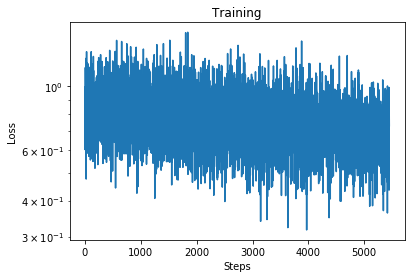

In [62]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import random

net = Net(n_feature=200, n_output=1)     # define the network
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  
batch_size = 64
epoch = 50
losses = []
batch_idx = np.array(list(range(len(X_train))))

for e in range(1, epoch+1):
    random.shuffle(batch_idx)
    for i in range(0, len(X_train)-batch_size, batch_size):
        curr_idx = batch_idx[i:i+batch_size]
        x = torch.Tensor(X_train[curr_idx])
        y = torch.Tensor(y_train_zh[curr_idx]).view(batch_size,-1)
        optimizer.zero_grad()
        prediction = net(x)    
        loss = loss_func(prediction, y)
        losses += [loss.item()]
        optimizer.zero_grad()   
        loss.backward()        
        optimizer.step()    
    with torch.no_grad():
        predictions = net(torch.Tensor(X_val)).flatten().data.numpy()
        pearson = pearsonr(y_val_zh, predictions)
        print(f'Epoch: {e} RMSE: {rmse(predictions,y_val_zh)} Pearson: {pearson[0]} MAE: {mean_absolute_error(predictions,y_val_zh)}')
plot_loss(losses)

## RNN

### GRU

In [65]:
zh_train_mt_m2 = get_sentence_embeddings_zh("data/en-zh/train.enzh.mt", mode=2)
zh_train_src_m2 = get_embeddings("data/en-zh/train.enzh.src", glove, nlp_en, mode=2)

zh_val_src_m2 = get_embeddings("data/en-zh/dev.enzh.src", glove, nlp_en, mode=2)
zh_val_mt_m2 = get_sentence_embeddings_zh("data/en-zh/dev.enzh.mt", mode=2)

zh_test_src_m2 = get_embeddings("data/en-zh/test.enzh.src", glove, nlp_en, mode=2)
zh_test_mt_m2 = get_sentence_embeddings_zh("data/en-zh/test.enzh.mt", mode=2)

In [66]:
def pad_to_max_length(sentences, max_len):
    return torch.stack(tuple(
                        F.pad(input=torch.tensor(l), pad=(0, 0, 0, max_len - l.shape[0]), mode='constant', value=0) 
                        for l in sentences))

max_len_zh_1 = max(l.shape[0] for l in zh_train_mt_m2)
max_len_en_1 = max(l.shape[0] for l in zh_train_src_m2)
max_len_zh_2 = max(l.shape[0] for l in zh_val_mt_m2)
max_len_en_2 = max(l.shape[0] for l in zh_val_src_m2)
max_len_zh_3 = max(l.shape[0] for l in zh_test_mt_m2)
max_len_en_3 = max(l.shape[0] for l in zh_test_src_m2)
max_len_zh = max(max_len_zh_1, max_len_zh_2, max_len_zh_3)
max_len_en = max(max_len_en_1, max_len_en_2, max_len_en_3)

zh_train_mt_pad = pad_to_max_length(zh_train_mt_m2, max_len_zh)
zh_train_src_pad = pad_to_max_length(zh_train_src_m2, max_len_en)
zh_val_src_pad = pad_to_max_length(zh_val_src_m2, max_len_en)
zh_val_mt_pad = pad_to_max_length(zh_val_mt_m2, max_len_zh)
zh_test_src_pad = pad_to_max_length(zh_test_src_m2, max_len_en)
zh_test_mt_pad = pad_to_max_length(zh_test_mt_m2, max_len_zh)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
input_dim = word_dim
hidden_dim=50

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, fc_dim, n_layers, drop_prob=0, bidirectional=True):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru_en = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob, bidirectional=bidirectional).to(device)
        self.gru_zh = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob, bidirectional=bidirectional).to(device)
        self.fc2 = nn.Linear(fc_dim, 64).to(device)
        self.fc3 = nn.Linear(64, 16).to(device)
        self.fc4 = nn.Linear(16, output_dim).to(device)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        x_en, x_zh = x[0].to(device), x[1].to(device)
        h_en, h_zh = h[0].to(device), h[1].to(device)
        out_en, h_en = self.gru_en(x_en, h_en)
        out_zh, h_zh = self.gru_zh(x_zh, h_zh)
        out = torch.cat((torch.mean(out_en, 1),torch.mean(out_zh, 1)), 1).view(batch_size, -1)
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

GRUNet(input_dim, hidden_dim, fc_dim=(1)*hidden_dim, output_dim=1, n_layers=2, drop_prob=0)

GRUNet(
  (gru_en): GRU(100, 50, num_layers=2, batch_first=True, bidirectional=True)
  (gru_zh): GRU(100, 50, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=50, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Epoch: 1 RMSE: 0.8962678 Pearson 0.1288151 MAE: 0.7225445
Epoch: 2 RMSE: 0.8960831 Pearson 0.1521229 MAE: 0.7192193
Epoch: 3 RMSE: 0.8961754 Pearson 0.1644464 MAE: 0.7151776
Epoch: 4 RMSE: 0.8951922 Pearson 0.1774726 MAE: 0.7218304
Epoch: 5 RMSE: 0.8950791 Pearson 0.1836817 MAE: 0.7171608
Epoch: 6 RMSE: 0.8943002 Pearson 0.1900831 MAE: 0.7238722
Epoch: 7 RMSE: 0.8938084 Pearson 0.1938209 MAE: 0.7217379
Epoch: 8 RMSE: 0.8934413 Pearson 0.1966581 MAE: 0.7168737
Epoch: 9 RMSE: 0.8925463 Pearson 0.2005183 MAE: 0.7241671
Epoch: 10 RMSE: 0.8918372 Pearson 0.2024515 MAE: 0.7173359
Epoch: 11 RMSE: 0.8912035 Pearson 0.2047099 MAE: 0.7129166
Epoch: 12 RMSE: 0.8900613 Pearson 0.2074416 MAE: 0.7120817
Epoch: 13 RMSE: 0.8893030 Pearson 0.2092757 MAE: 0.7072238
Epoch: 14 RMSE: 0.8872024 Pearson 0.2110440 MAE: 0.7118425
Epoch: 15 RMSE: 0.8856646 Pearson 0.2125411 MAE: 0.7107945
Epoch: 16 RMSE: 0.8839246 Pearson 0.2143446 MAE: 0.7134660
Epoch: 17 RMSE: 0.8826130 Pearson 0.2160177 MAE: 0.7041424
Epoch:

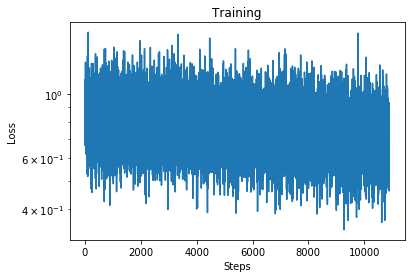

In [71]:
from scipy.stats.stats import pearsonr
import random

lr=0.01
batch_size = 64
epoch = 100
losses = []

X_en = zh_train_src_pad
X_zh = zh_train_mt_pad

gru = GRUNet(input_dim, hidden_dim, fc_dim=4*hidden_dim, output_dim=1, n_layers=2, drop_prob=0)
optimizer = torch.optim.SGD(gru.parameters(), lr)
loss_func = torch.nn.MSELoss() # lambda x, y : torch.nn.L1Loss()(x, y) + torch.nn.MSELoss()(x, y) + pearsonr_loss(x.flatten(), y.flatten())

h = gru.init_hidden(batch_size), gru.init_hidden(batch_size)
batch_idx = np.array(list(range(len(X_en))))
                     
for e in range(1, epoch+1):
    random.shuffle(batch_idx)
    for i in range(0, len(X_en)-batch_size, batch_size):
        curr_idx = batch_idx[i:i+batch_size]
        x = X_en[curr_idx], X_zh[curr_idx]
        y = torch.Tensor(y_train_zh[curr_idx]).view(batch_size,-1).cuda()
        optimizer.zero_grad()
        prediction, h = gru(x, h)
        loss = loss_func(prediction, y)  
        losses += [loss.item()]
        optimizer.zero_grad()   
        loss.backward()        
        optimizer.step()    
    
    with torch.no_grad():
        predictions = torch.zeros(0, batch_size)
        for i in range(0, len(zh_val_src_pad)-batch_size, batch_size):
            pred, _ = gru((zh_val_src_pad[i: i+batch_size], zh_val_mt_pad[i:i+batch_size]), h)
            pred = pred.permute(1,0)
            predictions = torch.cat((predictions, pred.cpu()), 0)
        predictions = predictions.flatten()
        y_val_trunc = torch.Tensor(y_val_zh[:len(predictions)-len(predictions)%batch_size])
        pearson = pearsonr(y_val_trunc, predictions)
        
        print(f'Epoch: {e} RMSE: {rmse(y_val_trunc, predictions):.7f} Pearson {pearson[0]:.7f} MAE: {mean_absolute_error(y_val_trunc, predictions):.7f}')
plot_loss(losses)

# Save results

In [87]:
# Concatenating training and validation set

zh_total_src = zh_train_src_m2 + zh_val_src_m2
zh_total_mt = zh_train_mt_m2 + zh_val_mt_m2
zh_total_mt_pad = pad_to_max_length(zh_total_mt, max_len_zh)
zh_total_src_pad = pad_to_max_length(zh_total_src, max_len_en)

y_total_zh = np.append(y_train_zh,y_val_zh)

Epoch: 1 loss: 0.8555318
Epoch: 2 loss: 0.8552448
Epoch: 3 loss: 0.8552321
Epoch: 4 loss: 0.8554848
Epoch: 5 loss: 0.8555601
Epoch: 6 loss: 0.8552780
Epoch: 7 loss: 0.8553765
Epoch: 8 loss: 0.8552971
Epoch: 9 loss: 0.8549055
Epoch: 10 loss: 0.8547030
Epoch: 11 loss: 0.8546765
Epoch: 12 loss: 0.8546610
Epoch: 13 loss: 0.8544625
Epoch: 14 loss: 0.8543599
Epoch: 15 loss: 0.8541704
Epoch: 16 loss: 0.8538792
Epoch: 17 loss: 0.8534942
Epoch: 18 loss: 0.8531979
Epoch: 19 loss: 0.8527074
Epoch: 20 loss: 0.8523658
Epoch: 21 loss: 0.8518301
Epoch: 22 loss: 0.8511595
Epoch: 23 loss: 0.8506094
Epoch: 24 loss: 0.8499709
Epoch: 25 loss: 0.8490893
Epoch: 26 loss: 0.8482227
Epoch: 27 loss: 0.8472712
Epoch: 28 loss: 0.8461546
Epoch: 29 loss: 0.8450428
Epoch: 30 loss: 0.8439303
Epoch: 31 loss: 0.8428637
Epoch: 32 loss: 0.8417006
Epoch: 33 loss: 0.8405887
Epoch: 34 loss: 0.8394955
Epoch: 35 loss: 0.8383347
Epoch: 36 loss: 0.8371949
Epoch: 37 loss: 0.8361009
Epoch: 38 loss: 0.8350171
Epoch: 39 loss: 0.833

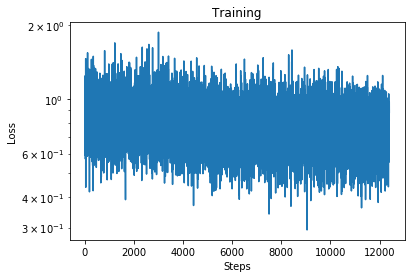

In [89]:
# Training best model on full training + validation dataset

losses = []
X_en = zh_total_src_pad
X_zh = zh_total_mt_pad

gru = GRUNet(input_dim, hidden_dim, fc_dim=4*hidden_dim, output_dim=1, n_layers=2, drop_prob=0)
optimizer = torch.optim.SGD(gru.parameters(), lr)
loss_func = torch.nn.MSELoss() # lambda x, y : torch.nn.L1Loss()(x, y) + torch.nn.MSELoss()(x, y) + pearsonr_loss(x.flatten(), y.flatten())

h = gru.init_hidden(batch_size), gru.init_hidden(batch_size)
batch_idx = np.array(list(range(len(X_en))))
                     
for e in range(1, epoch+1):
    random.shuffle(batch_idx)
    for i in range(0, len(X_en)-batch_size, batch_size):
        curr_idx = batch_idx[i:i+batch_size]
        x = X_en[curr_idx], X_zh[curr_idx]
        y = torch.Tensor(y_total_zh[curr_idx]).view(batch_size,-1).cuda()
        optimizer.zero_grad()
        prediction, h = gru(x, h)
        loss = loss_func(prediction, y)  
        losses += [loss.item()]
        optimizer.zero_grad()   
        loss.backward()        
        optimizer.step()    
    print(f'Epoch: {e} loss: {np.mean(losses[-len(X_en)-len(X_en)%batch_size:]):.7f}')
plot_loss(losses)

In [90]:
torch.save(gru.state_dict(), "modelGRU.pt")

In [98]:
predictions = torch.zeros(0, batch_size)
with torch.no_grad():
    for i in range(0, len(zh_test_src_pad)-batch_size, batch_size):
        pred, _ = gru((zh_test_src_pad[i: i+batch_size], zh_test_mt_pad[i:i+batch_size]), h)
        pred = pred.permute(1,0)
        predictions = torch.cat((predictions, pred.cpu()), 0)
    predictions = predictions.flatten()
    # Adding the predictions for the last entries not fitting in a batch
    predictions = torch.cat((predictions, gru((
                        zh_test_src_pad[len(zh_test_src_pad)-batch_size: len(zh_test_src_pad)], 
                        zh_test_mt_pad[len(zh_test_src_pad)-batch_size: len(zh_test_src_pad)]
                    ), h)[0][batch_size-len(zh_test_src_pad)%batch_size:].cpu().flatten()))
    predictions.shape

In [100]:
import os

def writeScores(scores):
    fn = "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            output_file.write(f"{x}\n")

In [102]:
writeScores(predictions)